In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
from memory_profiler import memory_usage
import gc


import dask.dataframe as dd


import pyarrow.dataset as ds
import rpy2.rinterface
import rpy2_arrow.pyarrow_rarrow as pyra
import pyarrow.feather as feather
import pyarrow.parquet as pq

In [2]:
%load_ext rpy2.ipython
%load_ext memory_profiler

# Milestone 1: Tackling big data on your laptop


---
## 1. Team-work contract

Teamwork contract available on Google Doc and linked separately in canvas submission.

---
## 2. Creating repository and project structure

Link to repository: https://github.com/UBC-MDS/grp15_rainfall_analysis

Link to milestone1 notebook: https://github.com/UBC-MDS/grp15_rainfall_analysis/blob/main/notebooks/milestone1_final.ipynb

---
## 3. Downloading the data

### 3.1 Download the data from [figshare](https://figshare.com/articles/dataset/Daily_rainfall_over_NSW_Australia/14096681) to the local computer using the [figshare API](https://docs.figshare.com) using the `requests` library.

In [3]:
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figshare_rainfall"

In [4]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]
files

[{'is_link_only': False,
  'name': 'daily_rainfall_2014.png',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'id': 26579150,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'size': 58863},
 {'is_link_only': False,
  'name': 'environment.yml',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'id': 26579171,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'size': 192},
 {'is_link_only': False,
  'name': 'README.md',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'id': 26586554,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'size': 5422},
 {'is_link_only': False,
  'name': 'data.zip',
  'supplied_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'computed_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'id': 26766812,
  'download_url': 'https://

In [5]:
%%time
# all the CSV files we are interested in are located in data.zip file
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], os.path.join(output_directory, file["name"]))

CPU times: user 1.55 s, sys: 2.5 s, total: 4.05 s
Wall time: 45.7 s


### 3.2 Extract the zip file programmatically

In [6]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: user 13.9 s, sys: 2.33 s, total: 16.2 s
Wall time: 16.2 s


---
## 4. Combining data CSVs

- We used `pandas` approach to combine multiple CSVs into a single CSV.
- An extra column called "model" is added which identifies the model eg: for file name "SAM0-UNICON_daily_rainfall_NSW.csv", the model name is labelled as `SAM0-UNICON`
- The comparison of run times and memory usages using `pandas` approach on different machines within our team is documented in the GitHub [issue](https://github.com/UBC-MDS/grp15_rainfall_analysis/issues/5).
- We observed that memory increment is very high on all the machines, which means combining multiple CSVs into a single CSV file requires significant amount of memory.
- Run times for combining CSV files range between 5~8 minutes.  
    - *Junghoo*
        - peak memory: 7493.44 MiB, increment: 6857.14 MiB
        - CPU times: user 4min 41s, sys: 8.12 s, total: 4min 49s
        - Wall time: 4min 54s
    - *Micah*
         - peak memory: 2965.09 MiB, increment: 2425.31 MiB
         - CPU times: user 7min 28s, sys: 28.5 s, total: 7min 56s
         - Wall time: 8min 29s
    - *Chuang*
         - peak memory: 464.66 MiB, increment: 0.10 MiB
         - CPU times: user 6min 19s, sys: 17 s, total: 6min 36s
         - Wall time: 6min 51s 
    - *Pan*
         - peak memory: 3155.75 MiB, increment: 2882.34 MiB
         - CPU times: user 5min 50s, sys: 24.3 s, total: 6min 15s
         - Wall time: 6min 24s  



In [7]:
### just listing to get an idea how individual file looks like 
sample_df = pd.read_csv(os.path.join(output_directory, "ACCESS-CM2_daily_rainfall_NSW.csv"))
sample_df.columns

Index(['time', 'lat_min', 'lat_max', 'lon_min', 'lon_max', 'rain (mm/day)'], dtype='object')

In [8]:
### making sure that all files have the same columns
files = glob.glob(os.path.join(output_directory, "*.csv"))
use_cols = list(sample_df.columns)
for file in files:
    try:
        pd.read_csv(file, index_col=0, usecols=use_cols)
    except:
        df = pd.read_csv(file, index_col=0)
        print(f"{os.path.basename(file)} does not have all columns. {os.path.basename(file)} only has {df.columns.to_list()} columns.")

observed_daily_rainfall_SYD.csv does not have all columns. observed_daily_rainfall_SYD.csv only has ['rain (mm/day)'] columns.


In [9]:
%%time
%%memit
# "figshare_rainfall/observed_daily_rainfall_SYD.csv" is missing 'lat_min', 'lat_max', 'lon_min', 'lon_max' columns
files = glob.glob(os.path.join(output_directory, "*_NSW.csv"))

# combining using pandas method
df = pd.concat((pd.read_csv(file, index_col=0, usecols=use_cols)
                .assign(model = os.path.basename(file).split("_")[0])
                for file in files)
              )
df.to_csv(os.path.join(output_directory, "combined_data.csv"))

peak memory: 7292.71 MiB, increment: 6857.61 MiB
CPU times: user 4min 37s, sys: 6.97 s, total: 4min 44s
Wall time: 4min 44s


In [10]:
# free up memory
del df
gc.collect();

---
## 5. Load the combined CSV to memory and perform a simple EDA

### 5.1 Baseline `pandas` approach for comparison


#### ***Observation***
- We can see that the CPU time and Wall time are really close to each other, which suggests that there is only one CPU processing the work with no parallelization.
- We can also observe that the memory increment (> 8000 MiB) is very high, which means loading the entire dataset and performing EDA on the entire set consume a lot of memory.

In [11]:
%%time
%%memit
df = pd.read_csv("figshare_rainfall/combined_data.csv")
# find number of observations for each model
print(f"Counts of observations for each model: \n{df['model'].value_counts()}\n")
# see how many rows in the dataset
print(f"Number of rows: {df.shape[0]}\n")
# find maximum rain in mm/day
print(f"Maximum rain in mm/day: {df['rain (mm/day)'].max()}\n")

Counts of observations for each model: 
MPI-ESM1-2-HR       5154240
CMCC-ESM2           3541230
TaiESM1             3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
SAM0-UNICON         3541153
GFDL-CM4            3219300
FGOALS-f3-L         3219300
GFDL-ESM4           3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NESM3                966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64

Number of rows: 62467843

Maximum rain in mm/day: 432.9395145177841

peak memory: 10009.21 MiB, increment: 8495.11 MiB
CPU times: user 44.6 s, sys: 3.85 s, total: 48.4 s
Wall ti

### 5.2 Changing dtype of the data to reduce memory usage while performing EDA

#### ***Observation***
- By changing the dtype of the 5 out of 7 columns from `float64` to `float32`, we can significantly cut down the memory used to represent the data.

**Note**: cells in this section have been commented out because having both `df` and `df_reduced_dtype` in memory requires large amount of memory and sometimes leads the notebook kernel to crash. For reference, screenshots from running the cells are included below each cell that has been commented out.

In [12]:
# numeric_columns = ['lat_min', 'lat_max', 'lon_min', 'lon_max', 'rain (mm/day)']

In [13]:
# %%time
# %%memit
# df_reduced_dtype = df.copy()
# df_reduced_dtype[numeric_columns] = df_reduced_dtype[numeric_columns].astype('float32', errors='ignore')
# # find number of observations for each model
# print(f"Counts of observations for each model: \n{df_reduced_dtype['model'].value_counts()}\n")
# # see how many rows in the dataset
# print(f"Number of rows: {df_reduced_dtype.shape[0]}\n")
# # find maximum rain in mm/day
# print(f"Maximum rain in mm/day: {df_reduced_dtype['rain (mm/day)'].max()}")

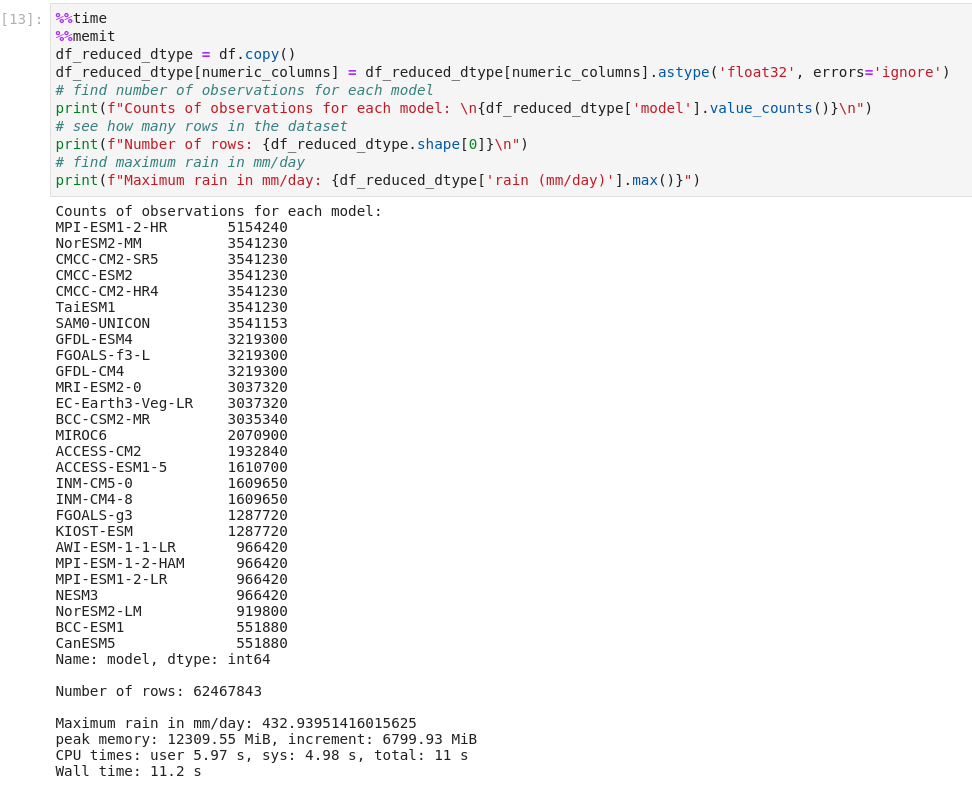

-  Note that although it may appear as if the CPU time and Wall time have decreased from the previous baseline approach, this is likely due to the fact that there is no reading from disk required in this approach. 
-  The main effect of this approach is the reduction in memory usage to store the dataframe object, as seen below.

In [14]:
# print(f"Memory usage with float64: {df.memory_usage().sum() / 1e6:.2f} MB")
# print(f"Memory usage with float32: {df_reduced_dtype.memory_usage().sum() / 1e6:.2f} MB")

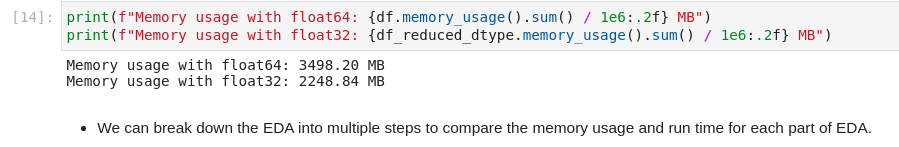

- We can break down the EDA into multiple steps to compare the memory usage and run time for each part of EDA. 

In [15]:
# %%time
# %%memit
# # find number of observations for each model
# print(f"Counts of observations for each model: \n{df['model'].value_counts()}\n")

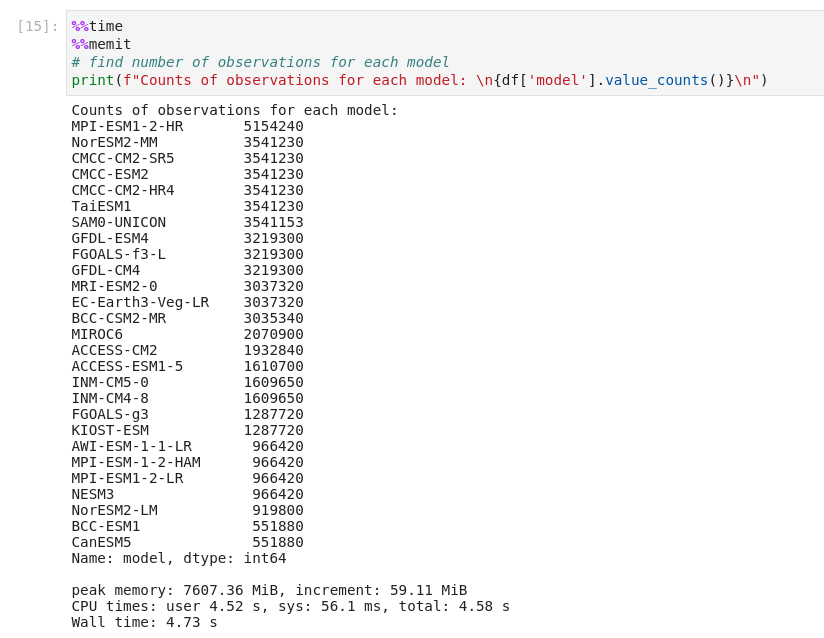

In [16]:
# %%time
# %%memit
# # find number of observations for each model
# print(f"Counts of observations for each model: \n{df_reduced_dtype['model'].value_counts()}\n")

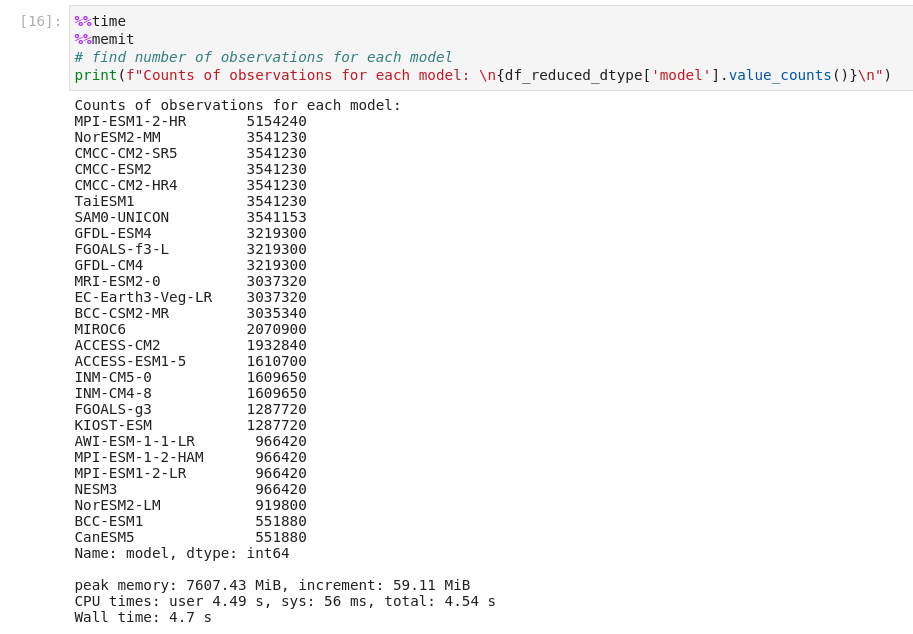

In [17]:
# %%time
# %%memit
# # see how many rows in the dataset
# print(f"Number of rows: {df.shape[0]}\n")

In [18]:
# %%time
# %%memit
# # see how many rows in the dataset
# print(f"Number of rows: {df_reduced_dtype.shape[0]}\n")

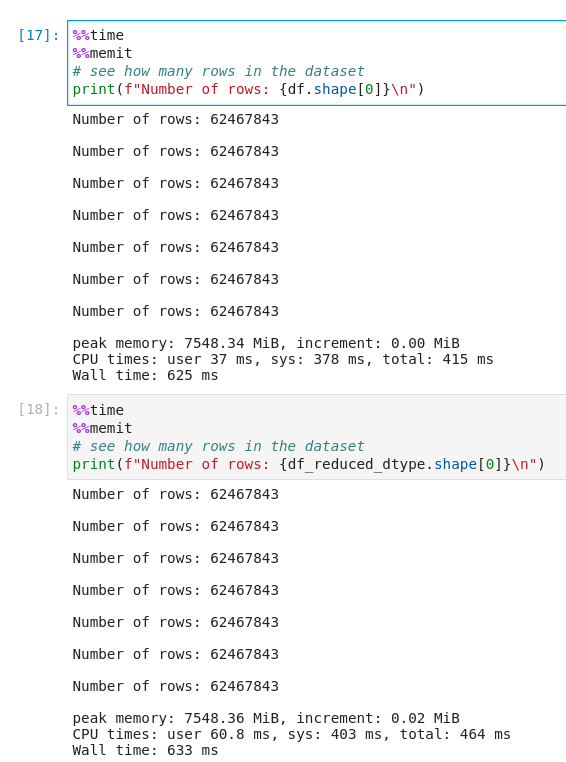

In [19]:
# %%time
# %%memit
# # find maximum rain in mm/day
# print(f"Maximum rain in mm/day: {df['rain (mm/day)'].max()}\n")

In [20]:
# %%time
# %%memit
# # find maximum rain in mm/day
# print(f"Maximum rain in mm/day: {df_reduced_dtype['rain (mm/day)'].max()}\n")

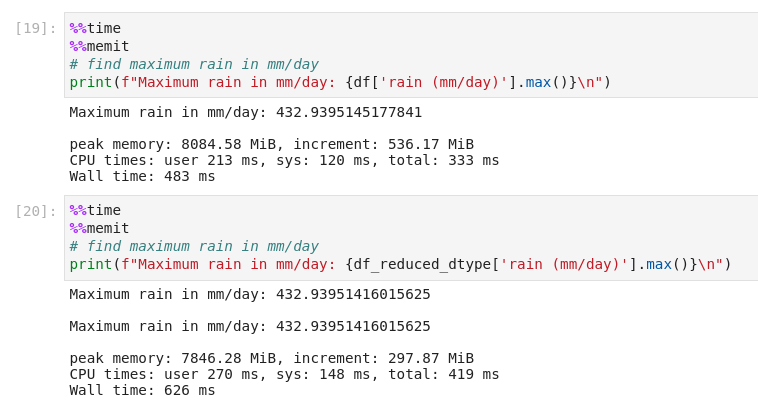

- We note from the above comparisons that there are some memory savings by using reduced dtype when performing columnwise operations such as finding number of observations for each model or finding maximum of a column (e.g. `rain (in mm/day)`). There is no memory savings by using reduced dtype when finding the number of rows since the `.shape` attribute is a part of the metadata of the dataframes and are not affected by changing the dtypes of the columns. Note that the results are slightly different because of the difference in floating point representations.

- There is no noticeable decrease in the CPU times, since the approach is fundamentally the same as the baseline approach and there is no parallel computing being done. 

In [21]:
# # free up memory
# del df_reduced_dtype
# gc.collect();

### 5.3 Loading in chunks
#### ***Observation***
- memory increment: approximately 2000 MiB is dramatically decreased (in comparison to over 8000 MiB using baseline approach) when we load data in small chunks.
- But the CPU time and Wall time are still close to each other, which means the work is still ***not*** executed in parallel.

In [22]:
%%time
%%memit
counts = pd.Series(dtype=int)
num_rows = 0
max_rain = 0.0
for chunk in pd.read_csv("figshare_rainfall/combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
    num_rows += chunk.shape[0]
    max_rain = max(max_rain, chunk["rain (mm/day)"].max())
# find number of observations for each model    
print(f"Counts of observations for each model: \n{counts}\n")
# see how many rows in the dataset
print(f"Number of rows: {num_rows}\n")
# find maximum rain in mm/day
print(f"Maximum rain in mm/day: {max_rain}")

Counts of observations for each model: 
ACCESS-CM2          1932840.0
ACCESS-ESM1-5       1610700.0
AWI-ESM-1-1-LR       966420.0
BCC-CSM2-MR         3035340.0
BCC-ESM1             551880.0
CMCC-CM2-HR4        3541230.0
CMCC-CM2-SR5        3541230.0
CMCC-ESM2           3541230.0
CanESM5              551880.0
EC-Earth3-Veg-LR    3037320.0
FGOALS-f3-L         3219300.0
FGOALS-g3           1287720.0
GFDL-CM4            3219300.0
GFDL-ESM4           3219300.0
INM-CM4-8           1609650.0
INM-CM5-0           1609650.0
KIOST-ESM           1287720.0
MIROC6              2070900.0
MPI-ESM-1-2-HAM      966420.0
MPI-ESM1-2-HR       5154240.0
MPI-ESM1-2-LR        966420.0
MRI-ESM2-0          3037320.0
NESM3                966420.0
NorESM2-LM           919800.0
NorESM2-MM          3541230.0
SAM0-UNICON         3541153.0
TaiESM1             3541230.0
dtype: float64

Number of rows: 62467843

Maximum rain in mm/day: 432.9395145177841
peak memory: 8089.09 MiB, increment: 1540.62 MiB
CPU times: user 4

In [23]:
del chunk
gc.collect();

### 5.4 Dask approach

> using `dask` to read that csv file. Internally it's loading chunks and performing parallel computations.

#### ***Observation***
- memory increment: approximately 3000 MiB is dramatically decreased (compared to over 8000 MiB using baseline `pandas` approach) when we load data using `dask`.
- We note that the Wall time is much less than the CPU time now, which means the work is being done by several processors concurrently.

In [24]:
%%time
%%memit
ddf = dd.read_csv('figshare_rainfall/combined_data.csv')
# find number of observations for each model
print(f"Counts of observations for each model: \n{ddf['model'].value_counts().compute()}\n")
# see how many rows in the dataset
print(f"Number of rows: {ddf.shape[0].compute()}\n")
# find maximum rain in mm/day
print(f"Maximum rain in mm/day: {ddf['rain (mm/day)'].max().compute()}")

Counts of observations for each model: 
MPI-ESM1-2-HR       5154240
TaiESM1             3541230
NorESM2-MM          3541230
CMCC-CM2-HR4        3541230
CMCC-CM2-SR5        3541230
CMCC-ESM2           3541230
SAM0-UNICON         3541153
FGOALS-f3-L         3219300
GFDL-CM4            3219300
GFDL-ESM4           3219300
EC-Earth3-Veg-LR    3037320
MRI-ESM2-0          3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM5-0           1609650
INM-CM4-8           1609650
KIOST-ESM           1287720
FGOALS-g3           1287720
MPI-ESM1-2-LR        966420
NESM3                966420
AWI-ESM-1-1-LR       966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64

Number of rows: 62467843

Maximum rain in mm/day: 432.9395145177841
peak memory: 9453.95 MiB, increment: 2947.72 MiB
CPU times: user 3min 3s, sys: 24.9 s, total: 3min 28s
Wall t

In [25]:
# free up  memory
del ddf
gc.collect();

---
## 6. Perform a simple EDA in R

### Before picking an approach to transfer the data from python to R, we first look at how much memory and time is required to convert the dataframe into each format (arrow table, feather, and parquet), as well as how much space is required by each file format (CSV, feather, and parquet). 

In [26]:
# free up memory
columns = list(df.columns)
del df
gc.collect();

### a) converting to arrow table format

In [27]:
%%time
%%memit
#loading datasets
dataset = ds.dataset("figshare_rainfall/combined_data.csv", format="csv")
table = dataset.to_table(columns=columns)
# convert arrow table into an R format
r_table = pyra.converter.py2rpy(table)

5695
rarrow.ChunkedArray: 0.023442983627319336
5695
rarrow.ChunkedArray: 0.020330429077148438
5695
rarrow.ChunkedArray: 0.020914316177368164
5695
rarrow.ChunkedArray: 0.02625560760498047
5695
rarrow.ChunkedArray: 0.02008652687072754
5695
rarrow.ChunkedArray: 0.01974797248840332
5695
rarrow.ChunkedArray: 0.021179914474487305
peak memory: 6232.57 MiB, increment: 4228.59 MiB
CPU times: user 43.8 s, sys: 2.41 s, total: 46.2 s
Wall time: 47.7 s


In [28]:
del dataset
gc.collect();

### b) writing as feather format

In [29]:
%%time
%%memit
# writing to feather format
feather.write_feather(table, 'figshare_rainfall/combined.feather')

peak memory: 6237.46 MiB, increment: 5.93 MiB
CPU times: user 2.55 s, sys: 1.06 s, total: 3.61 s
Wall time: 2.12 s


### c) writing as parquet format

In [30]:
%%time
%%memit
## writing as a single parquet 
pq.write_table(table, 'figshare_rainfall/combined.parquet')

peak memory: 6368.04 MiB, increment: 130.55 MiB
CPU times: user 6.69 s, sys: 387 ms, total: 7.07 s
Wall time: 7.28 s


#### Compare the size of the data in 3 different format.

In [31]:
%%sh
# I am just seeing the size of the csv data
du -sh figshare_rainfall/combined_data.csv
# I am just seeing the size of the feather data
du -sh figshare_rainfall/combined.feather
# I am just seeing the size of the parquet data
du -sh figshare_rainfall/combined.parquet

5.6G	figshare_rainfall/combined_data.csv
1.1G	figshare_rainfall/combined.feather
539M	figshare_rainfall/combined.parquet


### 6.1 Transfering dataframe to R and trying to do simple EDA - `count(model)`

### a) `pandas` exchange before performing `count(model)`

> Note: We tried to load the entire dataset into R from python `pandas` dataframe, but it takes ages. Even loading just 1 million rows of the data, which is less than $\frac{1}{62} \approx 1.6%$ of the whole dataset and performing `count(model)` took roughly same amount of time as it did for the whole dataset in arrow table format. This indicates that the exchange of data between python `pandas` dataframe and R is a really expensive operation because of the serialization and deserialization, and therefore is not a recommended approach. 
>
> We commented out the following cell because running the notebook with the following cell would cause the kernel to break.

In [32]:
# %%time
# %%R -i df
# # NOTE: Attempting to run this cell to use pandas exchange approach results in notebook kernel crashing
# ## transferring the python dataframe to R
# start_time <- Sys.time()
# library(dplyr)
# print(class(df))
# result <- df %>% count(model)
# print(result)
# end_time <- Sys.time()
# print(end_time - start_time)

### b) arrow table exchange before performing `count(model)`

In [33]:
%%time
%%R -i r_table

## arrow Speed
start_time <- Sys.time()
print(class(r_table))
suppressMessages(library(dplyr))
# Arrow speed
result <- r_table %>% collect() %>% count(model)
print(class(r_table %>% collect()))
end_time <- Sys.time()
print(result)
print(end_time - start_time)
rm(r_table)
rm(result)
gc()

[1] "Table"       "ArrowObject" "R6"         
[1] "tbl_df"     "tbl"        "data.frame"
# A tibble: 27 x 2
   model                  n
   <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
# … with 17 more rows
Time difference of 7.462229 secs
          used (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells 1587261 84.8    3093172  165.2   3093172  165.2
Vcells 2804665 21.4  414730436 3164.2 600994261 4585.3
CPU times: user 9.31 s, sys: 7.04 s, total: 16.4 s
Wall time: 8.04 s


### c) reading a feather file format before performing `count(model)`

In [34]:
%%time
%%R

### Feather speed
suppressMessages(library(arrow))
start_time <- Sys.time()
r_table <- arrow::read_feather("figshare_rainfall/combined.feather")
print(class(r_table))
suppressMessages(library(dplyr))
result <- r_table %>% count(model)
end_time <- Sys.time()
print(result)
print(end_time - start_time)
rm(r_table)
rm(result)
gc()

[1] "tbl_df"     "tbl"        "data.frame"
# A tibble: 27 x 2
   model                  n
   <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
# … with 17 more rows
Time difference of 6.755283 secs
          used (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells 1590878 85.0    3093172  165.2   3093172  165.2
Vcells 2813130 21.5  518568284 3956.4 600994261 4585.3
CPU times: user 7.65 s, sys: 5.52 s, total: 13.2 s
Wall time: 7.03 s


### d) reading a parquet file format before performing `count(model)`

In [35]:
%%time
%%R

### Parquet speed
suppressMessages(library(arrow))
start_time <- Sys.time()
r_table <- arrow::read_parquet("figshare_rainfall/combined.parquet")
print(class(r_table))
suppressMessages(library(dplyr))
result <- r_table %>% count(model)
end_time <- Sys.time()
print(result)
print(end_time - start_time)
rm(r_table)
rm(result)
gc()

[1] "tbl_df"     "tbl"        "data.frame"
# A tibble: 27 x 2
   model                  n
   <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
# … with 17 more rows
Time difference of 5.805744 secs
          used (Mb) gc trigger   (Mb)  max used   (Mb)
Ncells 1590917 85.0    3093172  165.2   3093172  165.2
Vcells 2813181 21.5  518568343 3956.4 600994261 4585.3
CPU times: user 7.52 s, sys: 4.94 s, total: 12.5 s
Wall time: 6.14 s


### 6.2 Transfering to R and trying to do simple EDA - `summary()`

> ### **Note**: Cells in this section are commented out because running the whole notebook from top to bottom would sometimes cause the kernel to break. 
>
> ### Section 6.1 has a similar example of transferring dataframe to R and performing another EDA using `count(model)`

### a) `pandas` exchange before performing `summary()`

> Note: Again, we tried to load the entire dataset into R from python `pandas` dataframe, but it takes ages. Even loading just 1 million rows of the data, which is less than $\frac{1}{62} \approx 1.6%$ of the whole dataset and performing `summary()` took roughly same amount of time as it did for the whole dataset in arrow table format. This indicates that the exchange of data between python `pandas` dataframe and R is a really expensive operation because of the serialization and deserialization, and therefore is not a recommended approach. 
>
> We commented out the following cell because running the notebook with the following cell would cause the kernel to break.

In [36]:
# %%time
# %%R -i df

# start_time <- Sys.time()
# library(dplyr)
# print(class(df))
# result <- df %>% collect() %>% summary()
# end_time <- Sys.time()
# print(result)
# print(end_time - start_time)

### b) arrow table exchange before performing `summary()`

In [37]:
# %%time
# %%R -i r_table

# ## arrow Speed - running summary()
# start_time <- Sys.time()
# print(class(r_table))
# suppressMessages(library(dplyr))
# # Arrow speed
# result <- r_table %>% collect() %>% summary()
# print(class(r_table %>% collect()))
# end_time <- Sys.time()
# print(result)
# print(end_time - start_time)
# rm(r_table)
# rm(result)
# gc()

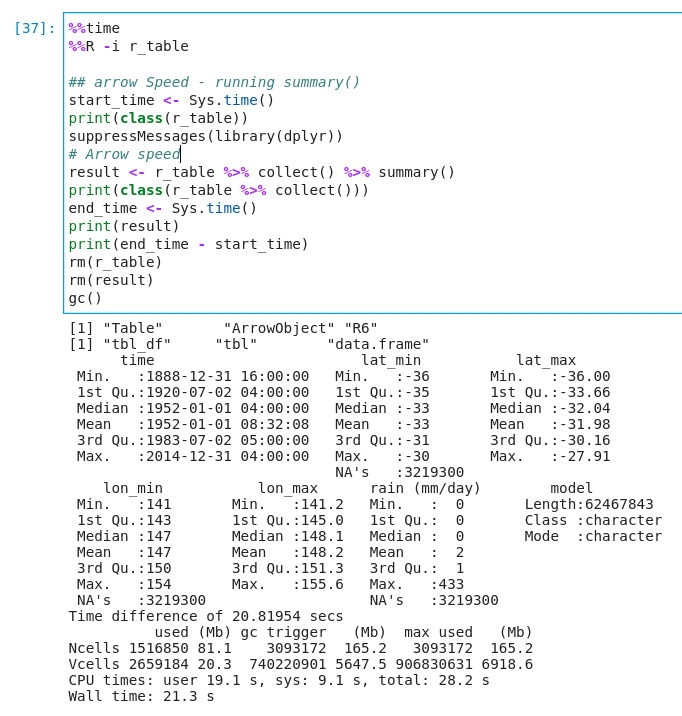

### c) reading a feather file format before performing `summary()`

In [38]:
# %%time
# %%R

# ### Feather speed - running summary()
# suppressMessages(library(arrow))
# start_time <- Sys.time()
# r_table <- arrow::read_feather("figshare_rainfall/combined.feather")
# print(class(r_table))
# suppressMessages(library(dplyr))
# result <- r_table %>% summary()
# end_time <- Sys.time()
# print(result)
# print(end_time - start_time)
# rm(r_table)
# rm(result)
# gc()

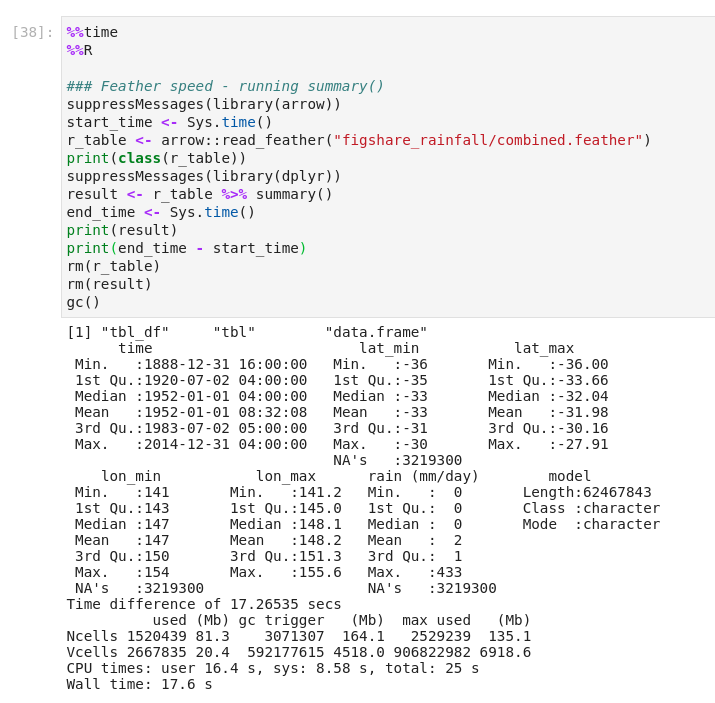

### d) reading a parquet file format before performing `summary()`

In [39]:
# %%time
# %%R

# ### Parquet speed - running summary()
# suppressMessages(library(arrow))
# start_time <- Sys.time()
# r_table <- arrow::read_parquet("figshare_rainfall/combined.parquet")
# print(class(r_table))
# suppressMessages(library(dplyr))
# result <- r_table %>% summary()
# end_time <- Sys.time()
# print(result)
# print(end_time - start_time)
# rm(r_table)
# rm(result)
# gc()

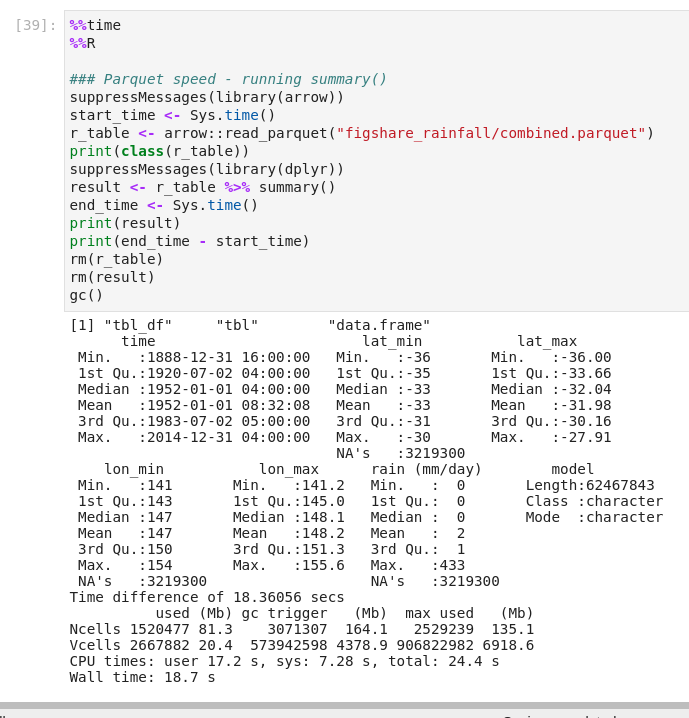

### **6.3 Final Decision**

Our group chose to use parquet to transfer the dataframe from Python to R. The file size for our combined data in parquet format was 539mb compared to 5.6GB and 1.1GB for csv and feather formats respectively. Meanwhile in the task of reading the file in R and running a simple `count(model)`, Wall time when using parquet format to perform `count(model)` EDA (6.14s) was noticeably shorter compared to the Wall times using arrow table exchange approach (8.04s) or using feather format (7.03s). Wall time when using parquet format to perform `summary()` EDA (18.7s) was noticeably shorter compared to the Wall time using arrow table exchange approach (21.3s), although it was slightly longer than using feather format (17.6s).

While there do not seem to be significant difference in speed between parquet and feather, parquet format seems to be the better option when we consider the file size of a parquet file compared to a feather file.  Thus we decided to go with the parquet format to transfer the dataframe to R and perform EDA. 

We did not consider importing the dataframe through `pandas` exchange approach using `%%R -i` because of the amount of serialization and deserialization that would need to be done when transferring it from Python to R.

---
## 7) Reflection

### Specific challenges or difficulties faced when dealing with this large data:

1. When trying to run this Jupyter notebook without freeing up the memory used by different instances of the dataframe, the notebook kernel kept crashing due to memory issues. This required a workaround by occasionally freeing up memories taken by unused dataframes, e.g. 

```python
del df
gc.collect()
```

and

```R
rm(r_table)
rm(result)
gc()
```


2. Trying to open `combined_data.csv` file using LibreOffice to manually inspect the saved file resulted in the following error message: 
> `The data could not be loaded completely because the maximum number of rows per sheet was exceeded.`

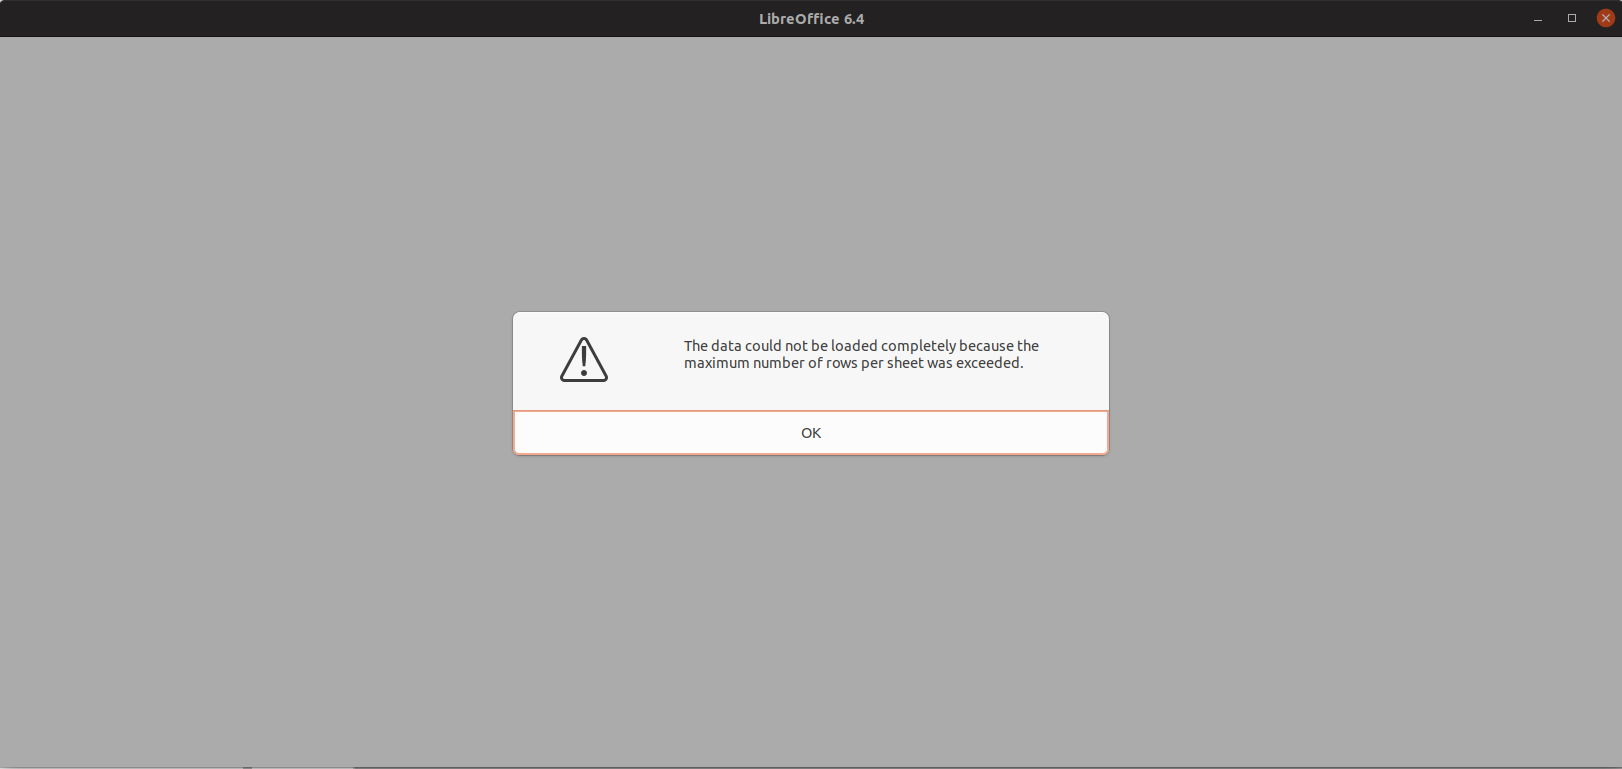